### Import Libraries

In [2]:
import numpy as np
import xarray as xr
import hsmm_mvpy as hmp
import matplotlib.pyplot as plt
from pathlib import Path
from mne import channels

### Load data

In [3]:
# Amount of cores to use in multiprocessing
cpus = 24

eeg_data = xr.load_dataset('data/sat1/data21-25.nc')

# Set up montage according to 10-20 system
montage = dict(channels.make_standard_montage('easycap-M1').get_positions())['ch_pos']

# Load x and y positions of electrodes
positions = np.array([montage[x][:2] for x in eeg_data['electrodes'].values])

output_path = Path('data/sat1/')


### Prepare data

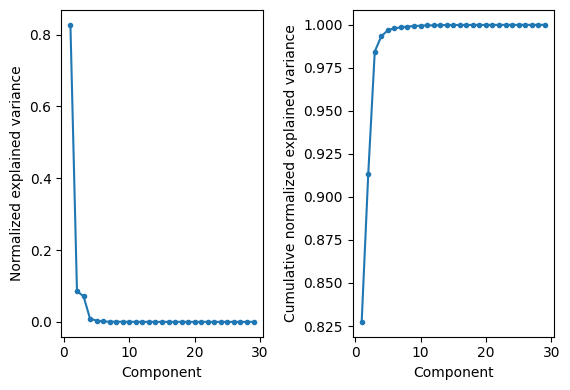

In [4]:
# Transform data into principal component (PC) space
# will ask in a pop-up how many components to keep
# selection depends on data size, choose number at cutoff (90/99%) or at 'elbow' point
hmp_data = hmp.utils.transform_data(eeg_data)

### Initialize models

In [6]:
hmp_accuracy_data = hmp.utils.condition_selection(hmp_data, eeg_data, 'AC')
model_accuracy = hmp.models.hmp(hmp_accuracy_data, eeg_data, event_width=50, cpus=cpus,
                                 sfreq=eeg_data.sfreq, estimate_magnitudes=False)

hmp_speed_data = hmp.utils.condition_selection(hmp_data, eeg_data, 'SP')
model_speed = hmp.models.hmp(hmp_speed_data, eeg_data, event_width=50, cpus=cpus,
                              sfreq=eeg_data.sfreq, estimate_magnitudes=False)

#### Regular fitting

In [7]:
fit_accuracy = model_accuracy.fit(step=1)
fit_speed = model_speed.fit(step=1)

  0%|          | 0/90 [00:00<?, ?it/s]

Transition event 2 found around sample 26
Transition event 3 found around sample 44
Transition event 4 found around sample 68
Estimating 4 events model
Parameters estimated for 4 events model


  0%|          | 0/53 [00:00<?, ?it/s]

Transition event 2 found around sample 24
Transition event 3 found around sample 47
Estimating 3 events model
Parameters estimated for 3 events model


In [15]:
# Takes a model and the probabilities of events occuring within the dataset the model was initiated on
# and returns an ndarray of shape samples x time x #electrodes
# length of labels must be equal to amount of events
# last_event_duration in samples, is the length of the eeg slice taken to represent the last event
def process_model(model, eeg_data, labels, last_event_duration=10):
    n_events = len(model.event)
    if len(labels) != n_events:
        return ValueError('Amount of labels is not equal to amount of events, adjust labels parameter')
    
    # Set up output datatypes
    event_locations = model.eventprobs.idxmax(dim='samples')
    stage_labels = []
    participant_labels = []
    stage_data = np.zeros((len(event_locations) * n_events, len(model.samples), len(eeg_data.electrodes)), dtype=np.float64)

    # For every known set of event locations, find the EEG data belonging to that trial (epoch) and participant
    for i, (locations, data) in enumerate(zip(event_locations, model.trial_x_participant)):
        data = data.item()
        locations = locations.values
        print(f'Processing participant {data[0]} and epoch {data[1]}')
        for j, location in enumerate(locations):
            # TODO: Change last_event_duration so it takes maximum sample length into account
            # Slice from known event location n to known event location n + 1
            # unless it is the last eventthen slice from known event location n to n + last_event_duration
            samples_slice = slice(location, locations[j + 1]) if j != n_events - 1 else slice(location, location + last_event_duration)
            eeg_slice = eeg_data.sel(participant=data[0], epochs=data[1], samples=samples_slice)['data'].T
            stage_data[i + j,0:len(eeg_slice),:] = eeg_slice
            stage_labels.append(labels[j])
            participant_labels.append(data[0])
    
    return stage_data, stage_labels, participant_labels


# Save data as .npz file containing both the data and belonging labels
def save_data(data, labels, participants, name):
    np.savez(output_path / name, data = data, labels = labels, participants=participants)

In [16]:
acc_data, acc_labels, acc_part = process_model(fit_accuracy, eeg_data, ['perception', '2', '3', 'motor'])
save_data(acc_data, acc_labels, acc_part, 'data21-25_AC')

Processing participant 0021 and epoch 0
Processing participant 0021 and epoch 1
Processing participant 0021 and epoch 4
Processing participant 0021 and epoch 5
Processing participant 0021 and epoch 6
Processing participant 0021 and epoch 7
Processing participant 0021 and epoch 9
Processing participant 0021 and epoch 10
Processing participant 0021 and epoch 15
Processing participant 0021 and epoch 17
Processing participant 0021 and epoch 19
Processing participant 0021 and epoch 21
Processing participant 0021 and epoch 26
Processing participant 0021 and epoch 28
Processing participant 0021 and epoch 35
Processing participant 0021 and epoch 39
Processing participant 0021 and epoch 41
Processing participant 0021 and epoch 42
Processing participant 0021 and epoch 43
Processing participant 0021 and epoch 44
Processing participant 0021 and epoch 46
Processing participant 0021 and epoch 47
Processing participant 0021 and epoch 50
Processing participant 0021 and epoch 51
Processing participant 

In [10]:
acc_data, acc_labels = process_model(fit_accuracy, eeg_data, ['perception', '2', '3', 'motor'])
save_data(acc_data, acc_labels, 'data21-25_AC')

sp_data, sp_labels = process_model(fit_speed, eeg_data, ['perception', '2', 'motor'])
save_data(sp_data, sp_labels, 'data21-25_SP')

Processing participant 0021 and epoch 0
Processing participant 0021 and epoch 1
Processing participant 0021 and epoch 4
Processing participant 0021 and epoch 5
Processing participant 0021 and epoch 6
Processing participant 0021 and epoch 7
Processing participant 0021 and epoch 9
Processing participant 0021 and epoch 10
Processing participant 0021 and epoch 15
Processing participant 0021 and epoch 17
Processing participant 0021 and epoch 19
Processing participant 0021 and epoch 21
Processing participant 0021 and epoch 26
Processing participant 0021 and epoch 28
Processing participant 0021 and epoch 35
Processing participant 0021 and epoch 39
Processing participant 0021 and epoch 41
Processing participant 0021 and epoch 42
Processing participant 0021 and epoch 43
Processing participant 0021 and epoch 44
Processing participant 0021 and epoch 46
Processing participant 0021 and epoch 47
Processing participant 0021 and epoch 50
Processing participant 0021 and epoch 51
Processing participant 

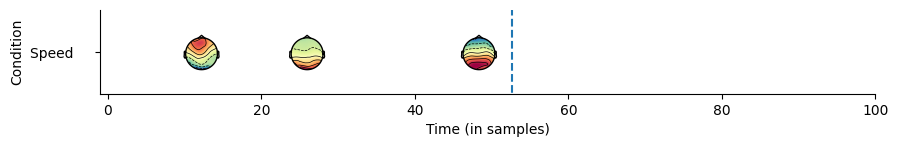

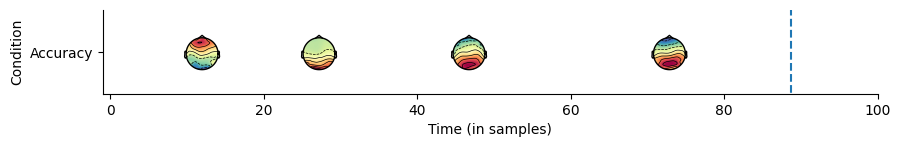

In [26]:
for condition in zip([fit_speed, fit_accuracy],
                     [model_speed, model_accuracy],
                     [hmp_speed_data, hmp_accuracy_data],
                    ['Speed    ', 'Accuracy']):
    hmp.visu.plot_topo_timecourse(eeg_data, condition[0],
                          positions, condition[1],  
                          times_to_display = np.mean(condition[1].ends - condition[1].starts),max_time=100,
                          figsize=(10,1), ylabels={'Condition':[condition[3]]})

In [80]:
eeg_data

<xarray.Dataset>
Dimensions:      (epochs: 200, electrodes: 30, samples: 210, participant: 4)
Coordinates:
  * epochs       (epochs) int64 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199
  * electrodes   (electrodes) object 'Fp1' 'Fp2' 'AFz' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) int32 0 1 2 3 4 5 6 7 ... 203 204 205 206 207 208 209
  * participant  (participant) object '0022' '0023' '0024' '0025'
Data variables:
    data         (participant, epochs, electrodes, samples) float64 3.19e+06 ...
    event        (participant, epochs) object 'AC/stim_right/resp_right' ... ...
Attributes:
    sfreq:    100
    offset:   0

In [8]:
fit_accuracy

<xarray.Dataset>
Dimensions:              (stage: 5, parameter: 2, event: 4, component: 4,
                          trial_x_participant: 454, samples: 210)
Coordinates:
  * event                (event) int32 0 1 2 3
  * samples              (samples) int32 0 1 2 3 4 5 ... 204 205 206 207 208 209
  * trial_x_participant  (trial_x_participant) object MultiIndex
  * participant          (trial_x_participant) object '0021' '0021' ... '0025'
  * trials               (trial_x_participant) int64 0 1 4 5 ... 179 180 184 187
Dimensions without coordinates: stage, parameter, component
Data variables:
    likelihoods          float64 5.383e+03
    parameters           (stage, parameter) float64 2.0 4.611 2.0 ... 2.0 11.05
    magnitudes           (event, component) float64 -1.731 -0.1936 ... -1.308
    eventprobs           (trial_x_participant, samples, event) float64 0.0 .....

In [11]:
# plt.plot(fit_accuracy.eventprobs[100,:,:])
# plt.show()
# print(fit_accuracy.eventprobs[100,:,:])

# for trial in fit_accuracy.eventprobs:
#     print(np.array(trial.idxmax(dim='samples')))
# eeg_data_txp.sel(samples=slice(1,10))
fit_accuracy.eventprobs

<xarray.DataArray 'eventprobs' (trial_x_participant: 374, samples: 210, event: 4)>
array([[[0.        , 0.        , 0.        , 0.        ],
        [0.00143225, 0.        , 0.        , 0.        ],
        [0.00546678, 0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        , 0.        ],
        [0.00219349, 0.        , 0.        , 0.        ],
        [0.00576926, 0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        , 0.        ],
        [0.00080108, 0.        , 0.        , 0.        ],
        [0.00055131, 0.        , 0.        , 0.        ],
        ...,
...
        ...,
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        , 0.        ],
        [0.00270941, 0.        , 0.        , 0.        ],
        [0.02188951, 0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        , 0.        ],
        [0.00279786, 0.        , 0.        , 0.        ],
        [0.04824297, 0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]]])
Coordinates:
  * event                (event) int32 0 1 2 3
  * samples              (samples) int32 0 1 2 3 4 5 ... 204 205 206 207 208 209
  * trial_x_participant  (trial_x_participant) object MultiIndex
  * participant          (trial_x_participant) object '0022' '0022' ... '0025'
  * trials               (trial_x_participant) int64 0 3 4 5 ... 174 175 179 181